 # Task
 
We are offered the opportunity to choose from the following tasks:

1. **Categorization of Unlabeled Products**: There are 1,257 products that lack assigned categories, corresponding to the `categories` field in the raw meta dataset.  
   - While this option holds potential business value, the provided model is not "efficient" for this task, as it is a decoder-only transformer.
   - We could consider using encoder-only transformers such as [DistilBERT](https://huggingface.co/docs/transformers/model_doc/distilbert) for fast text classification or FLAVA, which is an vision-language encoder model. So, we could use both images and text for classification. Both models would require to fine-tune. For an MVP we could also use API models like GPT-4o and Claude-3.5 (there are even more) if we want to explore a vision-language approach, even if they are decoder models.

2. **Enhancement of Product Taxonomy**: We could utilize the LLM to generate alternative categorizations.  
   - From a business perspective, this option appears less appealing, even though the model is suitable for text generation tasks.

3. **Sentiment Analysis and Product Reporting**: Using all products with more than 50 reviews in the dataset, we can generate a report for each product that, beyond review scores, reflects sentiment by highlighting the following information: safety issues, most and least appreciated features, price sentiment, etc.  
   - I find this option particularly interesting for two main reasons:
     1. **Business Value**: Providing feedback to retailers could be extremely beneficial. If the service is effective, they would likely pay for it, similar to the "insights" services currently offered by Amazon for advertisements. Ultimately, retailers aim to increase sales by enhancing visibility on their pages and by improving their products to meet customer preferences.
     2. **Model Suitability**: For this specific task, we have access to the Mistral 7B model, a decoder-only transformer specialized for text generation and understanding. 



In [48]:
import pandas as pd
import yaml
from pathlib import Path
import matplotlib.pyplot as plt
import os
from getpass import getpass
from langchain_huggingface import HuggingFaceEndpoint
from langchain.prompts import PromptTemplate
from langchain_core.output_parsers import JsonOutputParser, StrOutputParser

from pydantic_models.review_analysis import ReviewAnalysis

data_dir = Path('data')

In [ ]:
df_products = pd.read_parquet(data_dir / "df_products_filtered_50_reviews.parquet")
df_reviews = pd.read_parquet(data_dir / "df_reviews_filtered_50_reviews.parquet")

# 1 - Briefly explore data

We know there are 192 products with a total of ~20k reviews

## 1.1 - Product categories

In [23]:
df_products["main_category"].value_counts()

main_category
Baby                        141
Health & Personal Care       27
Amazon Home                  11
All Beauty                    4
AMAZON FASHION                2
Camera & Photo                2
Automotive                    2
Toys & Games                  1
Tools & Home Improvement      1
Sports & Outdoors             1
Name: count, dtype: int64

Theoretically, our primary focus is on baby products. However, I’ve observed other categories that even though they have a "strange name", seem to be relevant, even if their `main_category` values are somewhat unconventional. I don't think it's necessary to filter these out because my approach will be "inference-only" (meaning I won't be fine-tuning a model here). Furthermore, these categories do not appear to introduce any noise into the analysis. If I were dealing with a more critical issue or had more time, I might consider filtering them.

In [25]:
# df_products[df_products["main_category"]!= "Baby"]
df_products[df_products["main_category"] == "Tools & Home Improvement"]

,parent_asin,main_category,title,average_rating,rating_number,details,features
12465,B0B5F7WLL8,Tools & Home Improvement,ChoiceRefill Diaper Pail Refills - Compatible ...,4.7,8983,"{""Manufacturer"": ""Haoyunbao"", ""Part Number"": ""...",[]


## 1.2 - Number of reviews per product

In [11]:
df_reviews["parent_asin"].value_counts()

parent_asin
B0BJKYW5T7    555
B08K41XMBJ    510
B0BRY4L35M    433
B00ECHYTBI    425
B09VNZKJMY    417
             ... 
B00A4B34IA     51
B07317NQKW     51
B0BV4S59QV     51
B077TPC9Y7     51
B0BY8YWJWG     51
Name: count, Length: 192, dtype: int64

I can see that the majority of products have between 50 and 100 reviews. It may be enough for this exercise, but would need to explore it more. In addition, we *may not need* that many reviews as 500, as in a series of top products. We could probably try to find "different" reviews to get different perspectives of the data and extract more value.

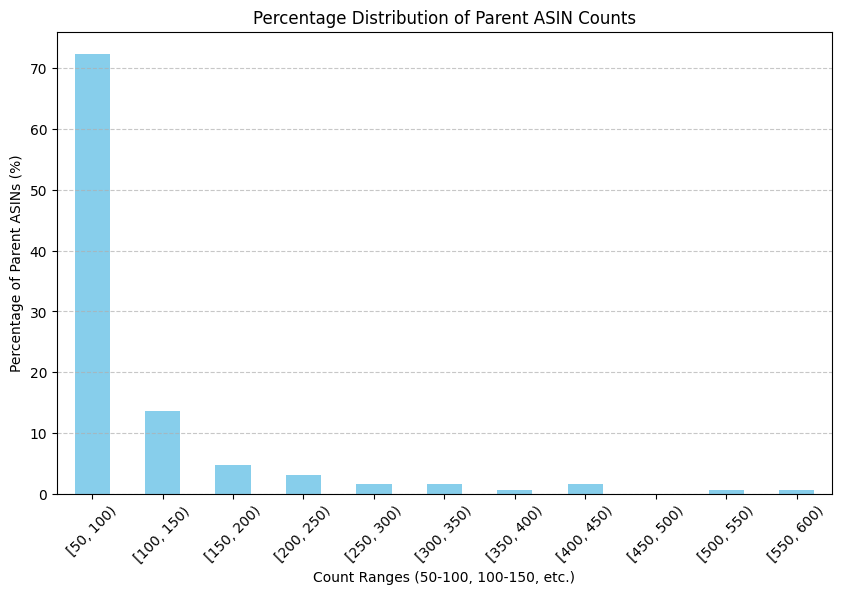

In [20]:
# Step 1: Calculate the counts of parent_asin
count_series = df_reviews['parent_asin'].value_counts()

# Step 2: Define bins for counts
bins = list(range(50, 601, 50))  # Create bins from 50 to 600 with a step of 50

# Step 3: Use pd.cut to categorize counts into bins
count_categories = pd.cut(count_series, bins, right=False)

# Count how many parent_asin fall into each bin
count_bins = count_categories.value_counts(sort=False)

# Step 4: Calculate percentages
percentage_bins = (count_bins / count_bins.sum()) * 100  # Convert to percentage

# Step 5: Plotting the results
plt.figure(figsize=(10, 6))
percentage_bins.plot(kind='bar', color='skyblue')
plt.title('Percentage Distribution of Parent ASIN Counts')
plt.xlabel('Count Ranges (50-100, 100-150, etc.)')
plt.ylabel('Percentage of Parent ASINs (%)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## 1.3 - Verified purchases

Not all of the reviews are verified purchases. For me, I would either drop those reviews that are not verified (a bit late now for this time-constrained task) or asign them less weight during summarization / pattern matching

I dont have much time, so I am going to ignore this unless I finish fast

In [36]:
df_reviews["verified_purchase"].value_counts()

verified_purchase
True     18475
False     1784
Name: count, dtype: int64

# 2 - Extract insights task

Our objective is to extract insights from these reviews so that we can provide value to Amazon sellers. There are different perspectives or aspects we could search for (especially considering we are going to focus on a specific category of products, i.e., Baby). 

If time allows, I will ask for ideas to GPT-4 and Claude

To start, we are going to focus on the following subtasks:

* `Bool`: Understand if there are safety issues (especially important since we are dealing with children's products). If True, explain which ones
* `List[str]`: What are the most appreciated features (if any)
* `List[str]`: What are the least appreciated features (if any)
* `Bool`: Is price ok?. Provide explanation
* `Bool`: Was shipping ok?. Provide explanation
* `Bool`: Was returned? If so, provide explanation why and if present, how well was the process
* `Bool`: Are there mentions of competing products? If so, which ones and what do clients say about them
    * Note: This could be complicated without proper context

Once we have categorized reviews this way, we could then summarize the main points and 

----

Notes: 

> **Langfuse:** I would use a `callback_handler` with [Langfuse](https://langfuse.com/) or a similar service to be able to take a look at the traces
 

> **Model:** I am not sure Mistral-7B is the best model for this task / my approach. It is a small model for complex reasoning task and as you will see below, I am going to ask it to do multiple things at the same time. If I had more time, I would benchmark it. Benchmark is complicated with LLMs in "complex" tasks as this one, I would probably do some human evaluation first comparing different models. Ideally I would like to have a deterministic metric for model comparison. If not, I can align a Judge LLM to my preferences and iterate with that.

-----

### Load the LLM

In [28]:
HUGGINGFACEHUB_API_TOKEN = getpass()
os.environ["HUGGINGFACEHUB_API_TOKEN"] = HUGGINGFACEHUB_API_TOKEN

In [32]:
repo_id = "mistralai/Mistral-7B-Instruct-v0.3"

llm = HuggingFaceEndpoint(
    repo_id=repo_id,
    max_length=128,
    temperature=0.5,
    huggingfacehub_api_token=HUGGINGFACEHUB_API_TOKEN,
)

WARNING! max_length is not default parameter.
                    max_length was transferred to model_kwargs.
                    Please make sure that max_length is what you intended.


The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: fineGrained).
Your token has been saved to /Users/fernando/.cache/huggingface/token
Login successful


### Prompts

I will begin by defining a two-phase prompt to evaluate each of the points discussed previously. The phases are as follows:

1. **Insight Generation**: In the first phase, I will use a prompt to ask the LLM to provide insights based on the subtasks defined earlier concerning the reviews.
   
2. **Formatting the Response**: In the second phase, I will instruct the LLM to format its answer according to a Pydantic model.

This two-part approach is intentional, as several researchers have noted that requiring the LLM to deliver structured outputs directly can diminish the quality of the response. For further reading, see this article: [The Downsides of Structured Outputs](https://www.llmwatch.com/p/the-downsides-of-structured-outputs).

By allowing the model some creative freedom initially, I can later guide it to present the information in a structured format. Additionally, we could utilize two different models, one for each task, to optimize the output.


In [43]:
def load_prompts():
    """Load prompts from a YAML file in the current working directory."""
    current_dir = os.getcwd()  # Get the current working directory in Jupyter
    prompts_file = os.path.join(current_dir, "prompts.yaml")
    with open(prompts_file) as file:
        return yaml.safe_load(file)

In [44]:
prompts = load_prompts()

### Create chains 

Notes: 

* **I would use different models for the insights task and for the formatting task.** The formatting task is quite "easy" for LLMs, while the first one can be complex. for instance, in other problems I usually use GPT-4o for the main task and GPT-4o-mini for simpler tasks like formatting. This is because GPT-4o-mini has very good performance 15x times cheaper.
    * We could also have smaller, but fine-tuned models (just as an example)



In [49]:
extract_insights_parser = StrOutputParser()
extract_insights_prompt_template = PromptTemplate.from_template(template=prompts["extract_insights"])
extract_insights_chain = extract_insights_prompt_template | llm | extract_insights_parser

format_insights_parser = json_parser = JsonOutputParser(pydantic_object=ReviewAnalysis)
format_insights_prompt_template = PromptTemplate.from_template(template=prompts["format_insights"])
format_insights_chain = format_insights_prompt_template | llm | format_insights_parser

## 2.1 - Extract insights

> I dont have much time so I am just going to showcase how it works with a single example

In [53]:
review = df_reviews.iloc[0]
review

parent_asin                                                 B076BBRPYH
title                                             Very disappointed...
text                 I believe the brand's quality and value just l...
verified_purchase                                                 True
Name: 0, dtype: object

In [56]:
extract_insights_data = {
    "amazon_review_title": review["title"],
    "amazon_review_text": review["text"],
}
review_llm_response = extract_insights_chain.invoke(
    input=extract_insights_data
)

In [59]:
print(review["text"])

I believe the brand's quality and value just like other seventh generation products, but I'm so disappointed about this diaper. My son's weight is within size 5 range, however the pee was leaked out of the diaper two times and I can't try anymore. Above all, it is too inconvenient that there is no detachable sticker on diaper even though it' a training diaper. I can't use scissors to take diaper out, thus it is such a nightmare that I have to undress all of his pants (actually 2 pants in winter in NY). I want a refund, but if it's too late, then I just want to return them without compensation. It's better to buy these to others who wants them.


In [58]:
print(review_llm_response)


1. **Safety Issues (Bool)**: True. The review mentions a safety issue related to the diaper's ability to contain urine, which is a critical safety concern for diapers.
2. **Most Appreciated Features (List[str])**:
   - Quality: The reviewer mentions that they believe the brand's quality is good, similar to other Seventh Generation products.
3. **Least Appreciated Features (List[str])**:
   - Leakage: The reviewer criticizes the diaper for leaking, which is a significant concern for diaper products.
   - Convenience: The reviewer expresses dissatisfaction with the inconvenience of having to undress their child multiple times due to the lack of a detachable sticker on the diaper.
4. **Price Evaluation (Bool)**: Not explicitly mentioned in the review. However, the reviewer does not mention the price as a concern, which could be interpreted as an indication that they find the price acceptable.
5. **Shipping Evaluation (Bool)**: Not explicitly mentioned in the review.
6. **Return Process E

## 2.2 - Format answer

In [61]:
format_insights_data = {
    "formatting_instructions": format_insights_parser.get_format_instructions(),
    "llm_response": review_llm_response
}

formatted_llm_response = format_insights_chain.invoke(
    input=format_insights_data
)

In [62]:
print(formatted_llm_response)

{'safety_issues': [True, "The review mentions a safety issue related to the diaper's ability to contain urine, which is a critical safety concern for diapers."], 'most_appreciated_features': ['Quality', "The reviewer mentions that they believe the brand's quality is good, similar to other Seventh Generation products."], 'least_appreciated_features': ['Leakage', 'Convenience', 'The reviewer expresses dissatisfaction with the inconvenience of having to undress their child multiple times due to the lack of a detachable sticker on the diaper.'], 'price_evaluation': [None, 'However, the reviewer does not mention the price as a concern, which could be interpreted as an indication that they find the price acceptable.'], 'shipping_evaluation': [None], 'return_process_evaluation': [True, "The reviewer mentions wanting a refund, but it's unclear if they went through the return process."], 'mentions_of_competing_products': [True, "The reviewer does not explicitly mention competing products, but t

By having a formatted answer, it is much easier for me to organize the further analysis and pattern matching. I have done a mix between classification and text generation. I can explain further if needed.

# Comments & Next Steps

This was my first time working with this data, so I spent more time than expected getting familiar with it and the variables. 
Now, I’ll outline the next steps.

What I've demonstrated here is a first MVP (minimum viable product) for extracting insights from the reviews. A few quick comments:

- While the main prompt is *not bad*, it could be improved by incorporating product-specific information. 
  This would give the LLM more context and help it better understand what customers are referring to. 
  Extracting insights is primarily a summarization task (rather than reasoning-intensive), so it's not critical, but it would still be beneficial.
  
- If this analysis were to be extended to other categories, I would introduce more flexibility to the prompt. 
  A meta-prompt could be used to generate category-specific prompts.
  
- I didn’t have time to implement the second phase, which involves summarizing the insights from the reviews into a report for the Amazon seller. 
  At its core, this would require defining a new prompt. I would likely process this in batches since we’re dealing with potentially dozens of insights per product.
  
- I also didn’t have time to filter the most interesting reviews, which is a crucial step for the summarization phase.
  
- Since sellers may improve their products and address issues over time, I would take the date of the reviews into account when generating the final report 
  (i.e., focusing on specific time periods rather than using all reviews). 
  There's also potential here for an interesting analysis on how seller actions impact reviews over time.
  
- The exercise suggested analyzing patterns based on star ratings, which I agree is valuable; these insights will likely be of great interest to the seller.

From an engineering standpoint, enhancing this MVP to address most of the points mentioned above shouldn’t be too complex; I just didn’t have the time. 
In a real-world scenario, I would also factor in execution time when refining the approach, as it might influence certain decisions.